In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
from tqdm.notebook import tqdm

import pickle
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
_individuals = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
individuals = _individuals.copy()
house_ids=[
    "2000989","2001197","2000914","2001123","2000964",
    "2001189","2001111","2001179","2000909","2000918",
    "2000994","2001107","2000913","2001139","2000960",
    "2001149","2001165","2000954","2001114","2000926",
]
house_ids = [house_ids[i] for i in [0, 4, 19, 13, 14]]
print(house_ids)

start = datetime(2019, 5, 30, 6, 0, 0)
end = start + timedelta(days=6, hours=23, minutes=45)

pv_size = 3
individuals = individuals.loc[start:end, house_ids + ["pv_1kw"]]
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

['2000989', '2000964', '2000926', '2001139', '2000960']


# Get perfect schedule

In [3]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries_quadratic:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "gurobi"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )
        
        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function_bis(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((1/netloads[i][p] * (m.batteryin[i, b] + m.batteryout[i, b]))**2 for b, p in zip(m.batteries, m.members))
                for i in m.horizon
            )
     
        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((m.batteryin[i, b] + m.batteryout[i, b])**2 for b in m.batteries)
                for i in m.horizon
            )
        m.objective = Objective(rule=objective_function_bis, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [4]:
perfect_schedules_concat = []
perfect_energy_concat = []
perfect_communityimport_concat = []

battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in house_ids]

model = OptimizeBatteries_quadratic(
    grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
    verbose=False, only_return_schedules=False)

delta = timedelta(minutes=15)
horizon = timedelta(days=7)
date_range = pd.date_range(start, end, freq="7D")
for jndex, start_optimization in tqdm(enumerate(date_range), desc="# Weeks", total=len(date_range)):

    end_optimization = start_optimization + horizon
    if end_optimization > end:
        end_optimization = end

    tmp_netload = individuals.loc[start_optimization:end_optimization, house_ids]
    schedule = model.solve(tmp_netload, house_ids, spec)

    # If not last iteration
    if not jndex == len(date_range) - 1:
        battery_time = start_optimization + horizon
        for i, house_id in enumerate(house_ids):
            spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

    perfect_schedules_concat.append(schedule["schedules"].loc[:start_optimization+horizon-delta].copy())
    perfect_energy_concat.append(schedule["batteryenergy"].loc[:start_optimization+horizon-delta].copy())
    perfect_communityimport_concat.append(schedule["community_import"].loc[:start_optimization+horizon-delta].copy())
perfect_schedules_concat = pd.concat(perfect_schedules_concat, axis=0)
perfect_energy_concat = pd.concat(perfect_energy_concat, axis=0)
perfect_communityimport_concat = pd.concat(perfect_communityimport_concat, axis=0)

# Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
graph = individuals.copy()
graph["community_kW"] = graph[house_ids].sum(axis=1)
graph.drop(house_ids, axis=1, inplace=True)

graph["storage"] = -perfect_schedules_concat.sum(axis=1)
graph["soc"] = perfect_energy_concat.sum(axis=1)


fig = px.line(graph.loc[start:start+timedelta(days=7), :],
              y=["community_kW", "storage", "soc"])

fig.data[2].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

In [ ]:
graph = perfect_communityimport_concat.loc[:end].copy()
graph.columns = ["check_perfect"]

graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], house_ids].sum(axis=1)
graph["pv_production_kw"] = pv_size * len(house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
print(f"Check PV size = {pv_size} kWp")

graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)

np.testing.assert_almost_equal(
    graph["Perfect"].sum(), graph["check_perfect"].sum(),
    decimal=7, verbose=True)
graph.drop(columns=["Total", "pv_production_kw", "check_perfect"], inplace=True)


graph = graph.cumsum(axis=0) / 4
graph = graph.resample("60T").last()

fig = px.line(graph.loc[:end, ["PV_only", "Perfect"]])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
#fig.write_image(f"results/cumsum_new_objective_func.svg")
#print(graph.tail(1))

# Get schedule from reactive control

In [5]:
def battery_constraints(in_kw, soc_kwh, spec, deltat_minute):
    # Energy
    offset = spec["max_kwh"] * spec["offset"]
    max_charg_kW = max(
        0, (spec["max_kwh"] - offset - soc_kwh) / (spec["eta"] * deltat_minute / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * spec["eta"] / (deltat_minute / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > spec["max_kw"]:
        in_kw = spec["max_kw"]

    if in_kw < -spec["min_kw"]:
        in_kw = -spec["min_kw"]
    return in_kw

def update_soc(in_kw, previous_soc_kwh, spec, deltat_minute):
    # Power
    assert in_kw <= spec["max_kw"], f"{in_kw} <= {spec['max_kw']}"
    assert in_kw >= -spec["min_kw"], f"{in_kw} >= {-spec['min_kw']}"

    # Energy
    if in_kw > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * in_kw * deltat_minute / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def collective_storage_control(df, house_names, deltat_minute, spec):
    """Change input df
    """
    if deltat_minute != 1:
        assert pd.infer_freq(df.index) == f"{deltat_minute}T"
    else:
        assert pd.infer_freq(df.index) == "T"
    
    in_kws = {name:list([0]) for name in house_names}
    soc_kwhs = {name:list([spec["max_kwh"] * spec["offset"]]) for name in house_names}
    
    for index, row in df[house_names].iterrows():
        netload = row.to_dict()
        
        if index.minute % 15 == 0:
            for name in house_names:
                in_kws[name].append(0)
                soc_kwhs[name].append(soc_kwhs[name][-1])
            
            last_netload = dict(netload)
            continue
            
        if (index.minute + deltat_minute) % 15 == 0:
            for name in house_names:
                last_netload[name] *= 2
        
        for name in house_names:
            in_kw = - last_netload[name]
            in_kw = battery_constraints(in_kw, soc_kwhs[name][-1], spec, deltat_minute)
            soc_kwh = update_soc(in_kw, soc_kwhs[name][-1], spec, deltat_minute)
            in_kws[name].append(in_kw)
            soc_kwhs[name].append(soc_kwh)
        
        community_netload = sum(last_netload[name] + in_kws[name][-1] for name in house_names)
        
        order = [(name, float(soc_kwhs[name][-1])) for name in house_names]
        if community_netload <= 0:
            order = sorted(order, key=lambda tup: tup[1], reverse=False)  # normal order 1, 2, 3 .. lowest soc
            assert order[0][1] <= order[-1][1]
        else:
            order = sorted(order, key=lambda tup: tup[1], reverse=True)  # Reverse normal order to get highest soc
            assert order[0][1] >= order[-1][1]
        
        # Overwrite individual commands for the most available batteries
        for name, _ in order:
            in_kw = in_kws[name][-1] - community_netload
            in_kw = battery_constraints(in_kw, soc_kwhs[name][-2], spec, deltat_minute)
            
            community_netload += in_kw - in_kws[name][-1]
            
            soc_kwh = update_soc(in_kw, soc_kwhs[name][-2], spec, deltat_minute)
            soc_kwhs[name][-1] = soc_kwh
            in_kws[name][-1] = in_kw
        
        last_netload = dict(netload)
    
    for name in house_names:
        del in_kws[name][0]    
        del soc_kwhs[name][0]     
        df[f"{name}_storage"] = in_kws[name]
        df[f"{name}_soc"] = soc_kwhs[name]
    return df

In [6]:
freq = "3T"
graph = individuals.copy()
graph = graph.resample(freq).ffill()
result = collective_storage_control(graph, house_ids, int(freq[0]), dict(ref_spec))

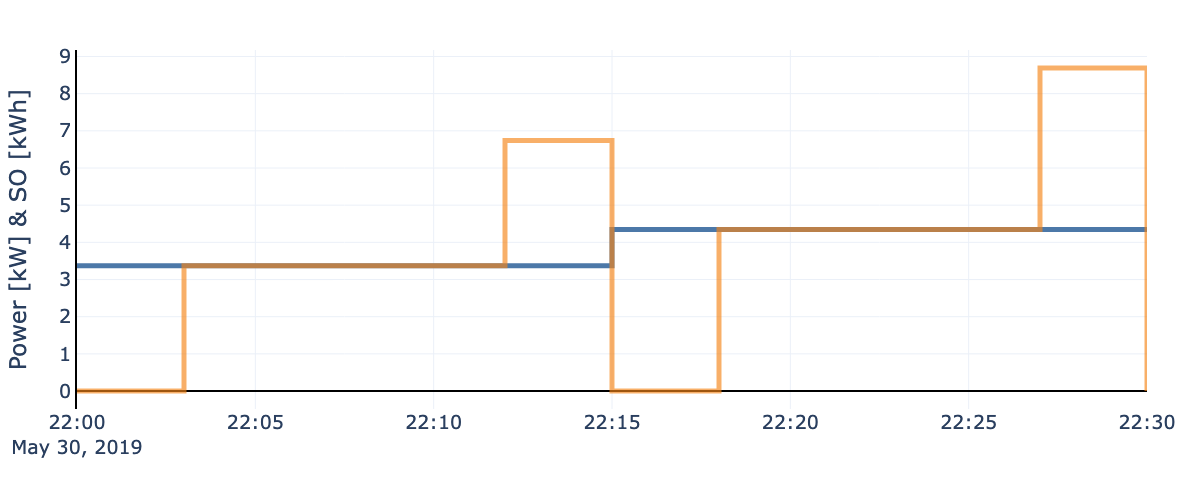

In [12]:
graph = result.copy()
graph["storage"] = -result[[f"{name}_storage" for name in house_ids]].sum(axis=1)
graph["soc"] = result[[f"{name}_soc" for name in house_ids]].sum(axis=1)

graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], house_ids].sum(axis=1).resample(freq).ffill()
graph["pv_production_kw"] = pv_size * len(house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"].resample(freq).ffill()
graph["community_kW"] = graph["Total"] - graph["pv_production_kw"]

#graph["community_kW"] = result[[f"{name}" for name in house_ids]].sum(axis=1)

fig = px.line(graph.loc[start+timedelta(hours=16):start+timedelta(hours=16, minutes=30), :],
              y=["community_kW", "storage"])
#fig.data[2].update(line_width=4, line_dash="dot")
fig.data[0].update(line_width=5)
fig.data[-1].update(line_width=5, opacity=0.65)
fig.update_traces(line_shape='hv')
fig.update_layout(
    layout,
    height=500,
    width=800,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/reactive_explained.svg")

Check PV size = 3 kWp


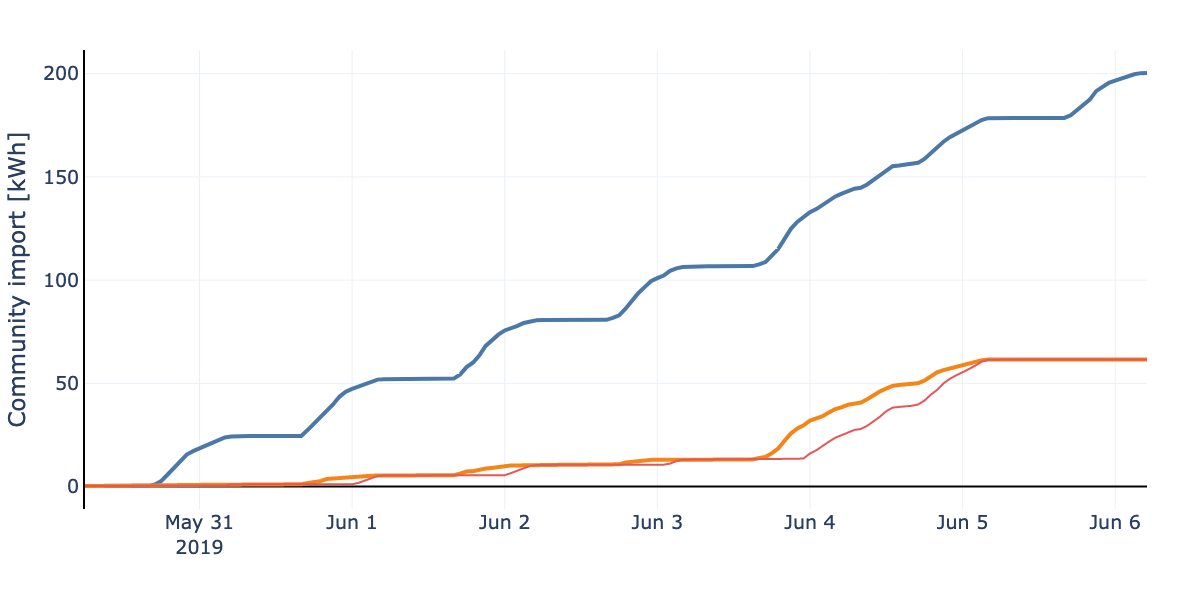

In [8]:
graph = perfect_communityimport_concat.loc[:end].copy()
graph.columns = ["check_perfect"]

graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], house_ids].sum(axis=1)
graph["pv_production_kw"] = pv_size * len(house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
print(f"Check PV size = {pv_size} kWp")

graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)
graph["Reactive"] = (graph["Total"].resample(freq).ffill() 
                     - graph["pv_production_kw"].resample(freq).ffill()
                     + result[[f"{name}_storage" for name in house_ids]].sum(axis=1)).resample("15T").mean().clip(lower=0)

np.testing.assert_almost_equal(
    graph["Perfect"].sum(), graph["check_perfect"].sum(),
    decimal=7, verbose=True)
graph.drop(columns=["Total", "pv_production_kw", "check_perfect"], inplace=True)

graph = graph.cumsum(axis=0) / 4
graph = graph.resample("60T").last()

fig = px.line(graph.loc[:end, ["PV_only", "Perfect", "Reactive"]])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/reactive_ffill_data.svg")

# Compare ending costs

In [297]:
def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [298]:
graph = perfect_schedules_concat.copy()
graph.columns = house_ids
for col in graph.columns:
    graph[col] += individuals.loc[start:end, col]

perfect_cost = community_bill(graph, house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Optimization cost = {np.round(perfect_cost, 2)} €")

Optimization cost = 11.61 €


In [304]:
graph = result.copy()
for col in house_ids:
    graph[col] += graph[f"{col}_storage"]

reactive_cost = community_bill(graph, house_ids, timing="15T", deltat=3, buy_price=0.1740, exchange_price=0.0371)
print(f"Reactive cost = {np.round(reactive_cost, 2)} €")

Reactive cost = 12.19 €


# Reactive with some random noise

Season-Trend decomposition using LOESS.

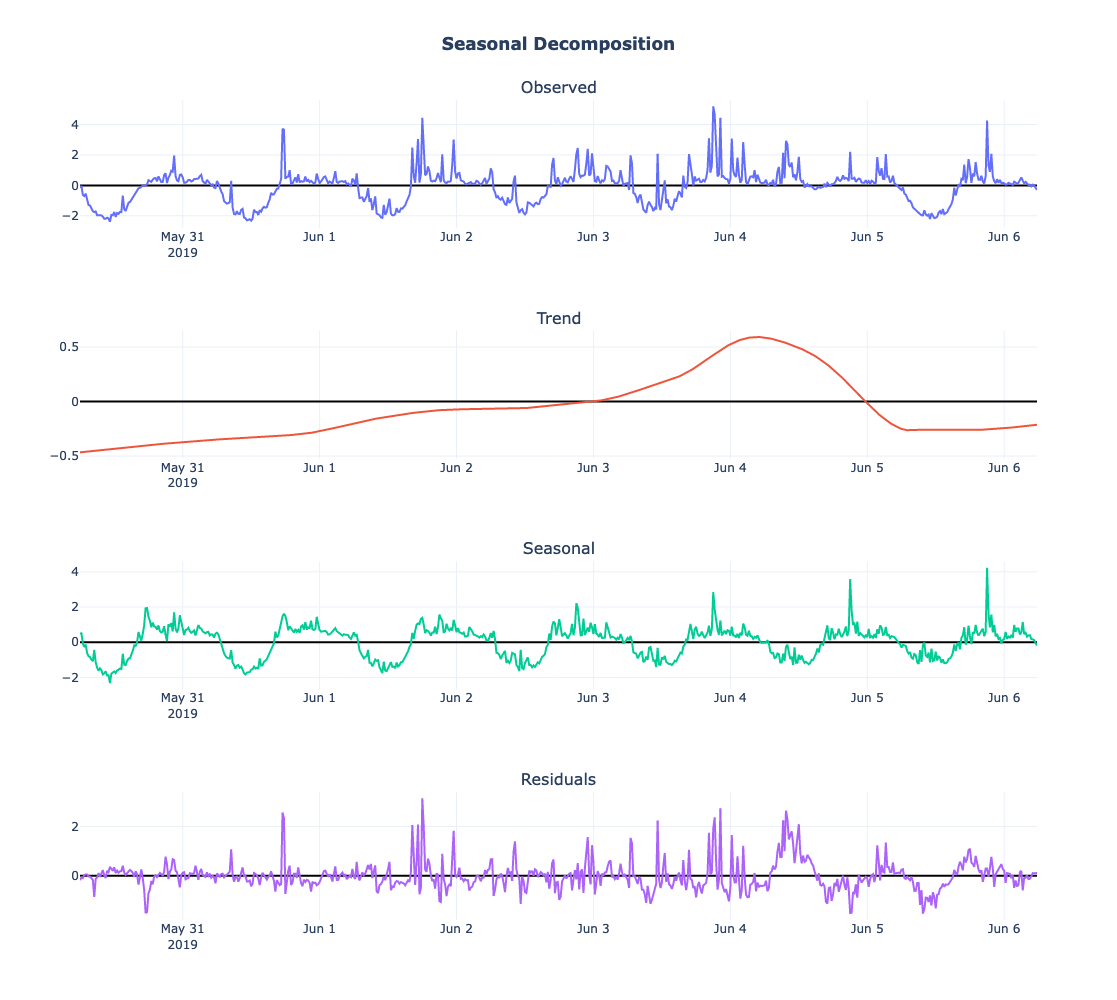

In [370]:
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go
from plotly.subplots import make_subplots

res = STL(individuals.loc[start:end, house_ids[2]].values, period=24*4).fit()
def plot_seasonal_decompose(result, dates, title="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            template="plotly_white",
            height=1000, width=1000,
            title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False,
            xaxis_zerolinewidth=2, xaxis_zerolinecolor="black",
            yaxis_zerolinewidth=2, yaxis_zerolinecolor="black",
            xaxis2_zerolinewidth=2, xaxis2_zerolinecolor="black",
            yaxis2_zerolinewidth=2, yaxis2_zerolinecolor="black",
            xaxis3_zerolinewidth=2, xaxis3_zerolinecolor="black",
            yaxis3_zerolinewidth=2, yaxis3_zerolinecolor="black",
            xaxis4_zerolinewidth=2, xaxis4_zerolinecolor="black",
            yaxis4_zerolinewidth=2, yaxis4_zerolinecolor="black",
        )
    )
fig = plot_seasonal_decompose(res, individuals.loc[start:end, :].index, title="Seasonal Decomposition")
fig.show()

In [372]:
from statsmodels.tsa.seasonal import STL

for name in house_ids:
    res = STL(_individuals.loc[start:end, name].values, period=24*4).fit()
    print(np.std(res.resid))

0.27120337817011136
0.19099020158346544
0.5159574733988332
0.311204285015864
0.13637995010031054


In [305]:
variance = 0.3

noise = individuals.copy()
noise = noise.resample(freq).ffill()

for name in house_ids:
    for _start in pd.date_range(noise.index[0], noise.index[-1], freq="1H"):
        _range = slice(_start, _start + timedelta(hours=1) - timedelta(minutes=3))
        sum_brefore = noise.loc[_range, name].sum()
        noise.loc[_range, name] += np.random.normal(0, variance, len(noise.loc[_range, name]))
        sum_after = noise.loc[_range, name].sum()
        noise.loc[_range, name] *= sum_brefore / sum_after

        np.testing.assert_almost_equal(
            sum_brefore, noise.loc[_range, name].sum(),
            decimal=6, verbose=True)
    
result = collective_storage_control(noise, house_ids, int(freq[0]), dict(ref_spec))

In [306]:
graph = result.copy()
for col in house_ids:
    graph[col] += graph[f"{col}_storage"]

reactive_cost = community_bill(graph, house_ids, timing="15T", deltat=3, buy_price=0.1740, exchange_price=0.0371)
print(f"Reactive cost = {np.round(reactive_cost, 2)} €")

Reactive cost = 13.26 €


Check PV size = 3 kWp


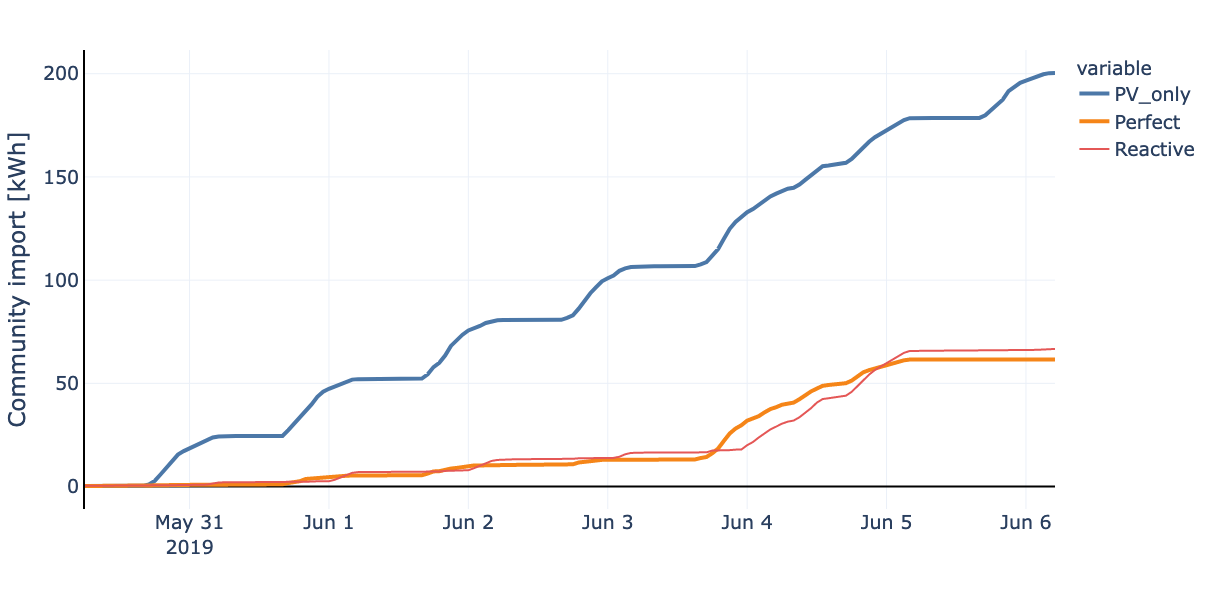

In [307]:
graph = perfect_communityimport_concat.loc[:end].copy()
graph.columns = ["check_perfect"]

graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], house_ids].sum(axis=1)
graph["pv_production_kw"] = pv_size * len(house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
print(f"Check PV size = {pv_size} kWp")

graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)
graph["Reactive"] = (result[[f"{name}" for name in house_ids]].sum(axis=1)
                     + result[[f"{name}_storage" for name in house_ids]].sum(axis=1)).resample("15T").mean().clip(lower=0)

np.testing.assert_almost_equal(
    graph["Perfect"].sum(), graph["check_perfect"].sum(),
    decimal=7, verbose=True)
graph.drop(columns=["Total", "pv_production_kw", "check_perfect"], inplace=True)

graph = graph.cumsum(axis=0) / 4
graph = graph.resample("60T").last()

fig = px.line(graph.loc[:end, ["PV_only", "Perfect", "Reactive"]])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=1050,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

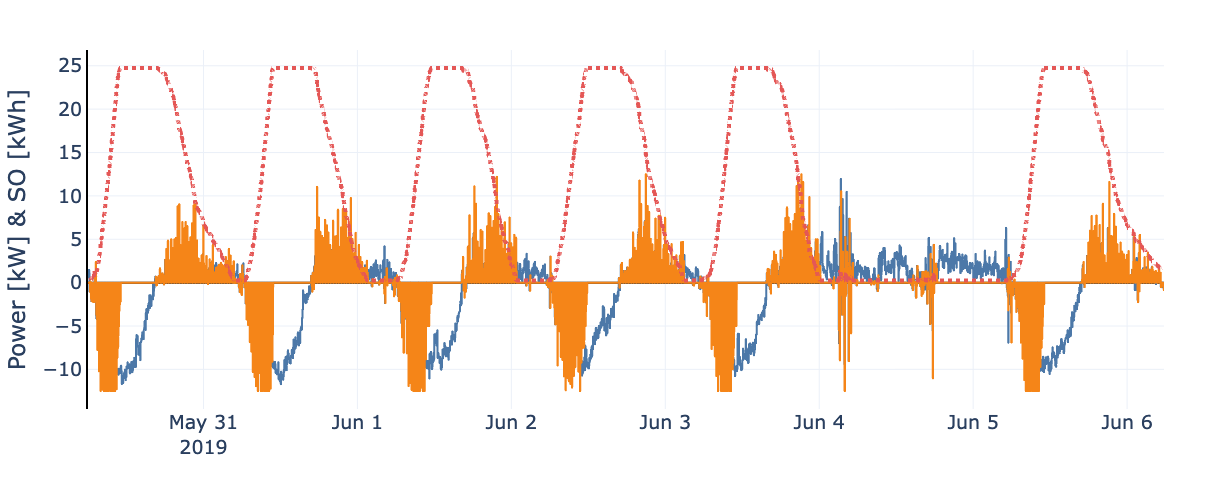

In [295]:
graph = result.copy()
graph["storage"] = -result[[f"{name}_storage" for name in house_ids]].sum(axis=1)
graph["soc"] = result[[f"{name}_soc" for name in house_ids]].sum(axis=1)
graph["community_kW"] = result[[f"{name}" for name in house_ids]].sum(axis=1)

fig = px.line(graph.loc[start:start+timedelta(days=7), :],
              y=["community_kW", "storage", "soc"])
fig.data[2].update(line_width=4, line_dash="dot")
fig.update_traces(line_shape='hv')
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

# Reactive with random noise cost distribution

In [373]:
variance = 0.3
costs = []

for j in tqdm(list(range(0, 1000)), desc="Sample"):
    noise = individuals.loc[start:end].copy()
    noise = noise.resample(freq).ffill()

    for name in house_ids:
        for _start in pd.date_range(noise.index[0], noise.index[-1], freq="2H"):
            _range = slice(_start, _start + timedelta(hours=1) - timedelta(minutes=3))
            sum_brefore = noise.loc[_range, name].sum()
            noise.loc[_range, name] += np.random.normal(0, variance, len(noise.loc[_range, name]))
            sum_after = noise.loc[_range, name].sum()
            noise.loc[_range, name] *= sum_brefore / sum_after

            np.testing.assert_almost_equal(
                sum_brefore, noise.loc[_range, name].sum(),
                decimal=6, verbose=True)

    result = collective_storage_control(noise, house_ids, int(freq[0]), dict(ref_spec))

    graph = result.copy()
    for col in house_ids:
        graph[col] += graph[f"{col}_storage"]

    reactive_cost = community_bill(graph, house_ids, timing="15T", deltat=3, buy_price=0.1740, exchange_price=0.0371)
    costs.append(reactive_cost)

Sample:   0%|          | 0/1000 [00:00<?, ?it/s]

13.4225
16.539921000000003


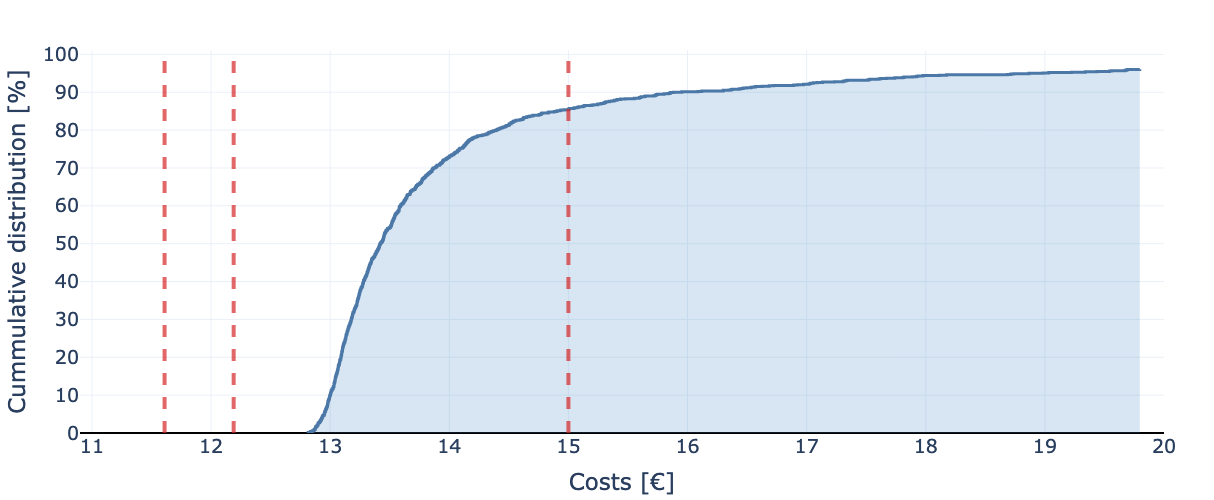

In [414]:
graph = pd.DataFrame(index=list(range(0, len(costs))), data={"costs": costs})
#graph = graph[graph.costs < 50]
print(graph.costs.median())
print(graph.costs.mean())


fig = px.ecdf(graph, x=["costs"], ecdfnorm="percent")
fig.data[0]["x"] = fig.data[0]["x"][:-39]
fig.data[0]["y"] = fig.data[0]["y"][:-39]
fig.update_traces(line_width=3, fillcolor="rgba(55, 128, 191, 0.2)", fill="tozeroy")

# Red dashed line
fig.add_shape(
 type='line',
 x0=11.61, x1=11.61, y0=0, y1=100,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=12.19, x1=12.19, y0=0, y1=100,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=15, x1=15, y0=0, y1=100,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    xaxis_range=[10.9, 20],
    xaxis_dtick=1,
    yaxis_dtick=10,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="Costs [€]",
    yaxis_title="Cummulative distribution [%]",
    yaxis_showline=False, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
)
fig.show()

In [415]:
fig.write_image(f"results/reactive_cummul_distribution.svg")